# Chess Games Database Analysis
This notebook analyzes the chess games database to understand player characteristics and patterns.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# print(plt.style.available)
# Set Matplotlib style
plt.style.use('seaborn-v0_8-dark-palette')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Connect to Database

In [2]:
DB_PATH = "../../data/processed/chess_games.db"
conn = sqlite3.connect(DB_PATH)

# Function to get table info
def get_table_info(table_name):
    return pd.read_sql(f"PRAGMA table_info({table_name})", conn)

# Get list of tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("Tables in database:")
display(tables)

Tables in database:


,name
0,chess_games
1,sqlite_sequence
2,player_features


# Number of games in each year

Year counts:


,year,games
0,None,396
1,1792,1
2,1793,1
3,1899,1
4,1909,1
...,...,...
62,2020,635286
63,2021,1751761
64,2022,1694473
65,2023,1576504


/var/folders/1r/jcq7c7353hsb6scsnq4g2pp00000gn/T/ipykernel_73008/902745310.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='games', data=year_counts, palette='viridis')


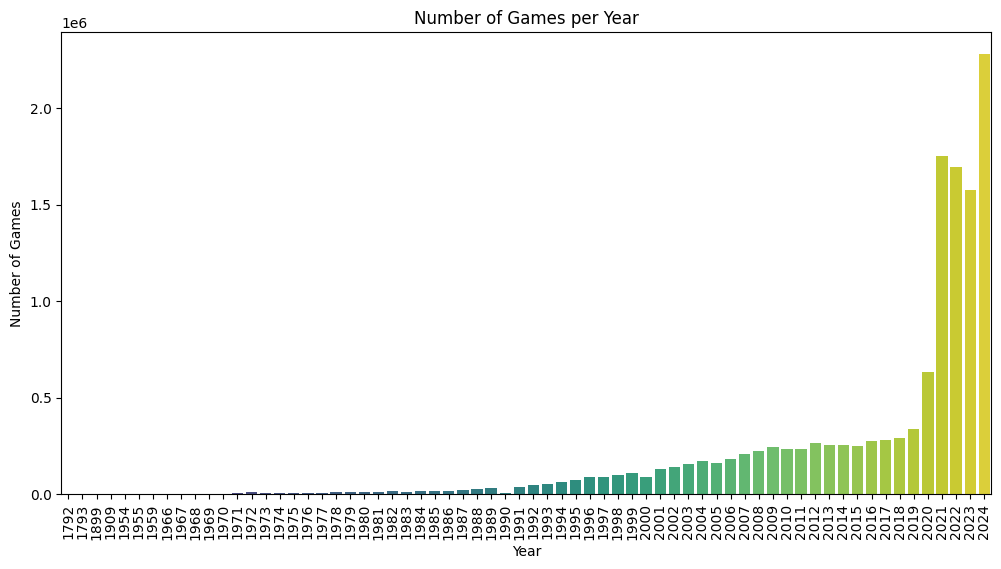

In [9]:
# Extract year from date and count games per year
year_counts = pd.read_sql("""
    SELECT SUBSTR(date, 1, 4) as year, COUNT(*) as games 
    FROM chess_games 
    GROUP BY year 
    ORDER BY year ASC
""", conn)
print("Year counts:")
display(year_counts)

# Plot bar graph of games per year
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='games', data=year_counts, palette='viridis')
plt.xticks(rotation=90)
plt.title('Number of Games per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.show()


In [25]:
# save unique players
unique_players = pd.read_sql("SELECT DISTINCT white FROM chess_games WHERE white_title = 'GM'", conn)
unique_players.to_csv("unique_players.csv", index=False)
# number of unique players
print(len(unique_players))


3533


In [ ]:
# value counts for event column from chess_games table
event_counts = pd.read_sql("SELECT event, COUNT(*) as games FROM chess_games GROUP BY event ORDER BY games DESC", conn)
print("Event counts:")
display(event_counts)

time_control_counts = pd.read_sql("SELECT time_control, COUNT(*) as games FROM chess_games GROUP BY time_control ORDER BY games DESC", conn)
print("Time control counts:")
display(time_control_counts)


Event counts:


,event,games
0,Blitz,5061004
1,None,3760718
2,Rapid,1213189
3,Classical,56081
4,Open,44684
...,...,...
40408,1. Division 2008 rounds 1-9,1
40409,1. Caledonian Masters,1
40410,1. Bundesliga 2008/9 rounds 1-3,1
40411,1 division 2002/03,1


Time control counts:


,time_control,games
0,None,10605412
1,180+0,3211312
2,600+0,714277
3,180+2,346108
4,180+1,51067
...,...,...
587,1080+9,1
588,1080+17,1
589,1020+7,1
590,0+7,1


## Basic Dataset Statistics

In [ ]:
# Get basic statistics
basic_stats = pd.read_sql("""
    SELECT 
        COUNT(*) as total_games,
        COUNT(DISTINCT white) as unique_white_players,
        COUNT(DISTINCT black) as unique_black_players,
        COUNT(DISTINCT white_elo) as unique_white_elos,
        COUNT(DISTINCT black_elo) as unique_black_elos,
        COUNT(DISTINCT eco) as unique_openings
    FROM chess_games
""", conn)

display(basic_stats)

,total_games,unique_white_players,unique_black_players,unique_white_elos,unique_black_elos,unique_openings
0,15321469,530267,540698,2901,2867,6161


# Null count

In [ ]:
def get_null_counts(table_name):
    # Get all columns first
    columns = pd.read_sql(f"PRAGMA table_info({table_name})", conn)['name']
    
    # Create null count query for each column
    null_counts = []
    for col in columns:
        null_counts.append(f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) as '{col}_null_count'")
    
    null_query = f"""
    SELECT {', '.join(null_counts)}
    FROM {table_name}
    """
    
    # Get total rows for percentage calculation
    total_rows = pd.read_sql(f"SELECT COUNT(*) as total FROM {table_name}", conn).iloc[0]['total']
    
    # Get null counts
    null_df = pd.read_sql(null_query, conn)
    
    # Reshape the dataframe
    result_df = pd.DataFrame({
        'column_name': columns,
        'null_count': null_df.iloc[0],
        'total_rows': total_rows
    })
    
    # Calculate null percentage
    result_df['null_percentage'] = (result_df['null_count'] / result_df['total_rows'] * 100).round(2)
    
    # Sort by null count in descending order
    result_df = result_df.sort_values('null_count', ascending=False)
    
    return result_df

# Get and display the null counts
null_analysis = get_null_counts('chess_games')
display(null_analysis)

,column_name,null_count,total_rows,null_percentage
eval_info_null_count,NaN,15268998.000,15321469,99.660
clock_info_null_count,NaN,15136493.000,15321469,98.790
opening_null_count,NaN,14984343.000,15321469,97.800
import_date_null_count,NaN,13054516.000,15321469,85.200
black_title_null_count,NaN,12953754.000,15321469,84.550
white_title_null_count,NaN,12943528.000,15321469,84.480
time_control_null_count,NaN,10605412.000,15321469,69.220
site_null_count,NaN,6521432.000,15321469,42.560
event_null_count,NaN,3760718.000,15321469,24.550
round_null_count,NaN,2341596.000,15321469,15.280


In [ ]:
# First let's count how many rows we have before deletion
before_count = pd.read_sql("SELECT COUNT(*) as count FROM chess_games", conn).iloc[0]['count']
print(f"Rows before deletion: {before_count:,}")

# Create and execute the deletion query
delete_query = """
DELETE FROM chess_games 
WHERE white IS NULL 
   OR black IS NULL 
   OR white_elo IS NULL 
   OR black_elo IS NULL 
   OR eco IS NULL 
   OR moves IS NULL
"""

# Execute the deletion
conn.execute(delete_query)
conn.commit()

# Count rows after deletion
after_count = pd.read_sql("SELECT COUNT(*) as count FROM chess_games", conn).iloc[0]['count']


print(f"Rows after deletion: {after_count:,}")
print(f"Rows deleted: {before_count - after_count:,}")

Rows before deletion: 15,321,469
Rows after deletion: 13,261,807
Rows deleted: 2,059,662


# Example row

In [3]:
# examine the first few rows of the chess_games table
chess_games = pd.read_sql("SELECT * FROM chess_games LIMIT 5", conn)
display(chess_games)


,id,event,site,date,round,white,black,result,white_elo,black_elo,white_title,black_title,eco,opening,time_control,import_date,source,moves,eval_info,clock_info,pgn
0,1,Blitz,None,2024.01.19,None,Abdallah1990,EzWin78,0-1,2510,2647,None,None,D00b,None,None,2024-03-19,LumbrasGigaBase,1.d4 d5 2.c3 Nf6 3.c4 e6 4.Nf3 Bb4+ 5.Bd2 Be7 ...,None,None,"[Event ""Blitz""] [Site ""?""] [Date ""2024.01.19""]..."
1,2,Blitz,None,2024.02.11,None,Abdallah1990,FranklinAPalomo,0-1,2452,2613,None,None,D06q,None,None,2024-03-19,LumbrasGigaBase,1.d4 d5 2.c4 Bf5 3.Nf3 e6 4.Nc3 Nf6 5.Nh4 Bg6 ...,None,None,"[Event ""Blitz""] [Site ""?""] [Date ""2024.02.11""]..."
2,3,Blitz,None,2024.07.12,-,Abdallah1990,Juvenilia,0-1,2503,2595,None,None,D06d,None,180+0,2024-10-01,LumbrasGigaBase,1.d4 d5 2.c4 c5 3.cxd5 Nf6 4.Nf3 cxd4 5.Qxd4 Q...,None,None,"[Event ""Blitz""] [Site ""?""] [Date ""2024.07.12""]..."
3,4,Blitz,None,2024.01.05,None,Abdallah1990,ConvTransformer,1/2-1/2,2462,2552,None,None,D07m,None,None,2024-03-19,LumbrasGigaBase,1.d4 d5 2.c4 Nc6 3.Nf3 Bg4 4.cxd5 Bxf3 5.gxf3 ...,None,None,"[Event ""Blitz""] [Site ""?""] [Date ""2024.01.05""]..."
4,5,Blitz,None,2024.07.15,-,Abdallah1990,Juvenilia,1-0,2474,2594,None,None,D06b,None,180+0,2024-10-01,LumbrasGigaBase,1.d4 d5 2.c4 c5 3.cxd5 Nf6 4.e4 Nxe4 5.dxc5 Nx...,None,None,"[Event ""Blitz""] [Site ""?""] [Date ""2024.07.15""]..."


## Game Results Analysis

In [ ]:
# Analyze game results
results_dist = pd.read_sql("""
    SELECT 
        result,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
    FROM chess_games
    GROUP BY result
    ORDER BY count DESC
""", conn)

plt.figure(figsize=(10, 6))
plt.pie(results_dist['percentage'], labels=results_dist['result'], autopct='%1.1f%%')
plt.title('Distribution of Game Results')
plt.show()

display(results_dist)

## Player Rating Distribution

In [ ]:
# Analyze rating distribution
elo_stats = pd.read_sql("""
    SELECT 
        AVG(white_elo) as avg_white_elo,
        AVG(black_elo) as avg_black_elo,
        MIN(white_elo) as min_white_elo,
        MAX(white_elo) as max_white_elo,
        MIN(black_elo) as min_black_elo,
        MAX(black_elo) as max_black_elo
    FROM chess_games
    WHERE white_elo IS NOT NULL AND black_elo IS NOT NULL
""", conn)

# Create histogram of ratings
ratings_query = """
    SELECT white_elo as elo, 'White' as color
    FROM chess_games
    WHERE white_elo IS NOT NULL
    UNION ALL
    SELECT black_elo as elo, 'Black' as color
    FROM chess_games
    WHERE black_elo IS NOT NULL
"""
ratings_df = pd.read_sql(ratings_query, conn)

plt.figure(figsize=(12, 6))
sns.histplot(data=ratings_df, x='elo', hue='color', bins=50, alpha=0.5)
plt.title('Distribution of Player Ratings')
plt.xlabel('Elo Rating')
plt.ylabel('Count')
plt.show()

display(elo_stats)

## Opening Analysis

In [ ]:
# Analyze most common openings
openings = pd.read_sql("""
    SELECT 
        eco,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
    FROM chess_games
    WHERE eco IS NOT NULL
    GROUP BY eco
    ORDER BY count DESC
    LIMIT 10
""", conn)

plt.figure(figsize=(15, 8))
sns.barplot(data=openings, x='percentage', y='eco')
plt.title('Top 10 Most Common ECO Codes')
plt.xlabel('Percentage of Games')
plt.tight_layout()
plt.show()

display(openings)


## Top Players Analysis

In [ ]:
# Analyze top players by number of games
top_players = pd.read_sql("""
    WITH player_games AS (
        SELECT white as player, result
        FROM chess_games
        UNION ALL
        SELECT black as player, result
        FROM chess_games
    )
    SELECT 
        player,
        COUNT(*) as total_games,
        SUM(CASE WHEN result = '1-0' THEN 1 ELSE 0 END) as wins,
        SUM(CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END) as draws,
        SUM(CASE WHEN result = '0-1' THEN 1 ELSE 0 END) as losses,
        ROUND(AVG(CASE 
            WHEN result = '1-0' THEN 1
            WHEN result = '1/2-1/2' THEN 0.5
            ELSE 0 END) * 100, 2) as win_percentage
    FROM player_games
    GROUP BY player
    HAVING total_games >= 10
    ORDER BY total_games DESC
    LIMIT 20
""", conn)

# Plot top 10 players by games played
plt.figure(figsize=(12, 6))
top_10 = top_players.head(10)
plt.bar(range(len(top_10)), top_10['total_games'])
plt.xticks(range(len(top_10)), top_10['player'], rotation=45, ha='right')
plt.title('Top 10 Players by Number of Games')
plt.ylabel('Number of Games')
plt.tight_layout()
plt.show()

display(top_players)

## Time Period Analysis

In [ ]:
# Analyze games by year
time_analysis = pd.read_sql("""
    WITH parsed_dates AS (
        SELECT 
            CAST(substr(date, 1, 4) AS INTEGER) as year,
            result
        FROM chess_games
        WHERE date IS NOT NULL
        AND date != ''
        AND length(date) >= 4
    )
    SELECT 
        year,
        COUNT(*) as total_games,
        SUM(CASE WHEN result = '1-0' THEN 1 ELSE 0 END) as white_wins,
        SUM(CASE WHEN result = '0-1' THEN 1 ELSE 0 END) as black_wins,
        SUM(CASE WHEN result = '1/2-1/2' THEN 1 ELSE 0 END) as draws
    FROM parsed_dates
    WHERE year >= 1950 AND year <= 2024
    GROUP BY year
    ORDER BY year
""", conn)

# Plot games per year
plt.figure(figsize=(15, 6))
plt.plot(time_analysis['year'], time_analysis['total_games'])
plt.title('Number of Games per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot win percentages over time
time_analysis['white_win_pct'] = time_analysis['white_wins'] / time_analysis['total_games'] * 100
time_analysis['black_win_pct'] = time_analysis['black_wins'] / time_analysis['total_games'] * 100
time_analysis['draw_pct'] = time_analysis['draws'] / time_analysis['total_games'] * 100

plt.figure(figsize=(15, 6))
plt.plot(time_analysis['year'], time_analysis['white_win_pct'], label='White Wins')
plt.plot(time_analysis['year'], time_analysis['black_win_pct'], label='Black Wins')
plt.plot(time_analysis['year'], time_analysis['draw_pct'], label='Draws')
plt.title('Game Outcomes Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

display(time_analysis)

## Game Length Analysis

In [ ]:
def count_moves(moves_str):
    if not moves_str:
        return 0
    return len(moves_str.split())

# Create a temporary function in SQLite
conn.create_function("count_moves", 1, count_moves)

# Analyze game lengths
game_lengths = pd.read_sql("""
    SELECT 
        count_moves(moves) as num_moves,
        COUNT(*) as games,
        result
    FROM chess_games
    WHERE moves IS NOT NULL
    GROUP BY num_moves, result
    HAVING num_moves > 0 AND num_moves < 200
""", conn)

plt.figure(figsize=(15, 6))
sns.histplot(data=game_lengths, x='num_moves', weights='games', hue='result', bins=50)
plt.title('Distribution of Game Lengths by Result')
plt.xlabel('Number of Moves')
plt.ylabel('Number of Games')
plt.legend(title='Result')
plt.tight_layout()
plt.show()

# Average game length by result
avg_length = pd.read_sql("""
    SELECT 
        result,
        AVG(count_moves(moves)) as avg_moves,
        MIN(count_moves(moves)) as min_moves,
        MAX(count_moves(moves)) as max_moves,
        COUNT(*) as num_games
    FROM chess_games
    WHERE moves IS NOT NULL
    GROUP BY result
""", conn)

display(avg_length)

## Player Performance Analysis

In [ ]:
# Analyze player performance by rating range
rating_performance = pd.read_sql("""
    WITH rating_ranges AS (
        SELECT 
            CASE 
                WHEN white_elo < 1600 THEN 'Under 1600'
                WHEN white_elo BETWEEN 1600 AND 1799 THEN '1600-1799'
                WHEN white_elo BETWEEN 1800 AND 1999 THEN '1800-1999'
                WHEN white_elo BETWEEN 2000 AND 2199 THEN '2000-2199'
                WHEN white_elo BETWEEN 2200 AND 2399 THEN '2200-2399'
                ELSE '2400+'
            END as rating_range,
            result
        FROM chess_games
        WHERE white_elo IS NOT NULL
    )
    SELECT 
        rating_range,
        COUNT(*) as games,
        ROUND(AVG(CASE 
            WHEN result = '1-0' THEN 1
            WHEN result = '1/2-1/2' THEN 0.5
            ELSE 0 END) * 100, 2) as win_percentage
    FROM rating_ranges
    GROUP BY rating_range
    ORDER BY MIN(CASE 
        WHEN rating_range = 'Under 1600' THEN 1
        WHEN rating_range = '1600-1799' THEN 2
        WHEN rating_range = '1800-1999' THEN 3
        WHEN rating_range = '2000-2199' THEN 4
        WHEN rating_range = '2200-2399' THEN 5
        ELSE 6 END)
""", conn)

plt.figure(figsize=(12, 6))
sns.barplot(data=rating_performance, x='rating_range', y='win_percentage')
plt.title('Win Percentage by Rating Range')
plt.xlabel('Rating Range')
plt.ylabel('Win Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(rating_performance)

## Move Pattern Analysis

In [ ]:
# Analyze first moves
first_moves = pd.read_sql("""
    WITH first_move AS (
        SELECT 
            SUBSTR(moves, 1, INSTR(moves, ' ') - 1) as move,
            result
        FROM chess_games
        WHERE moves IS NOT NULL
    )
    SELECT 
        move,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage,
        ROUND(AVG(CASE 
            WHEN result = '1-0' THEN 1
            WHEN result = '1/2-1/2' THEN 0.5
            ELSE 0 END) * 100, 2) as success_rate
    FROM first_move
    GROUP BY move
    HAVING count >= 100
    ORDER BY count DESC
""", conn)

plt.figure(figsize=(12, 6))
top_moves = first_moves.head(10)
plt.bar(range(len(top_moves)), top_moves['percentage'])
plt.xticks(range(len(top_moves)), top_moves['move'], rotation=45)
plt.title('Most Common First Moves')
plt.ylabel('Percentage of Games')
plt.tight_layout()
plt.show()

display(first_moves)

## Opening Success Analysis

In [ ]:
# Analyze opening success rates
opening_success = pd.read_sql("""
    WITH opening_stats AS (
        SELECT 
            eco,
            result,
            COUNT(*) as games,
            SUM(CASE 
                WHEN result = '1-0' THEN 1
                WHEN result = '1/2-1/2' THEN 0.5
                ELSE 0 END) as white_score
        FROM chess_games
        WHERE eco IS NOT NULL
        GROUP BY eco
        HAVING games >= 100
    )
    SELECT 
        eco,
        games,
        ROUND(white_score / games * 100, 2) as white_win_percentage
    FROM opening_stats
    ORDER BY white_win_percentage DESC
    LIMIT 20
""", conn)

plt.figure(figsize=(15, 8))
top_10_openings = opening_success.head(10)
sns.barplot(data=top_10_openings, x='white_win_percentage', y='eco')
plt.title('Top 10 ECO Codes by White Win Percentage')
plt.xlabel('White Win Percentage')
plt.tight_layout()
plt.show()

display(opening_success)


## Close Database Connection

In [ ]:
# Close the database connection
conn.close()